# Capstone Project: Explore Neighborhoods in Downtown Toronto

## Introduction:

For this project, it will be required to explore and cluster the neighborhoods in Toronto, and explore related information for restaurants among those neighborhood.

## Problem Description

In Toronto, if someone is looking to open a restaurant, where would you recommend that they open it?

## Data Description

For this assignment, the Foursquare API will be utilized to pull the following location data on restaurants and business in Toronto, Ontario

Venue Name  
Venue ID  
Venue Location  
Venue Category  
Count of Likes  

Let's start from importing BeautifulSoup and other packages and scrape the tabular geo data from the Wikipedia page first.  
The tabular data contains postal code, borough, andneighborhood information about Toronto.

In [1]:
#!pip3 install beautifulsoup4
#!pip3 install requests

import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize

response = requests.get(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M",)
print(response.status_code)
soup = BeautifulSoup(response.content, 'html.parser')
title = soup.find(id="firstHeading")
pretty_soup = soup.prettify()
print (soup.title.string)

all_tables=soup.find_all('table')
# get right table to scrap
right_table=soup.find('table', {"class":'wikitable sortable'})
# number of columns in the table
for row in right_table.findAll("tr"):
    cells = row.findAll('td')
print ("number of columns:",len(cells))
# number of rows in the table including header
rows = right_table.findAll("tr")
print ("number of rows including title:",len(rows))
# header attributes of the table
header = [th.text.rstrip() for th in rows[0].find_all('th')]
print("hearders:", header, "number of headers:",len(header))


200
List of postal codes of Canada: M - Wikipedia
number of columns: 3
number of rows including title: 181
hearders: ['Postal Code', 'Borough', 'Neighbourhood'] number of headers: 3


In [2]:
# Get tabular data (a list of lists)
lst_data = []
for row in rows[1:]:
            data = [d.text.rstrip() for d in row.find_all('td')] # select also works as find_all
            lst_data.append(data)


# Change it to DataFrame
df = pd.DataFrame.from_records(lst_data, columns = header)
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [3]:
# Drop rows with not assigned values in Borough column
# And combined rows which have the same postal codes

df2 = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df2.drop(df2[(df2.Borough == 'Not assigned')].index, inplace=True)

# If neighbourhood is 'Not assignmend', then let it be the same value as borough
for n in df2.index:
    if df2.at[n,'Neighbourhood'] == 'Not assigned':
        df2.at[n,'Neighbourhood'] = df2.at[n,'Borough'] 
df2.head()

,Postal Code,Borough,Neighbourhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [4]:
df2.shape

(103, 3)

## Graphical Data for Toronto

Get the latitude and longitude for each postal code.  
Here we use the given csv file which contains corresponding axis for each post code,
since the geocoder package is quite unstable

In [5]:
#!pip3 install geocoder
#import geocoder


#def get_geocoder(postal_code):
#    lis = []
#    lat_lng_coords = None
#    while(lat_lng_coords is None):
#        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#        lat_lng_coords = g.latlng

#    latitude = lat_lng_coords[0]
#    longitude = lat_lng_coords[1]
#    lis.append(atitude)
#    lis.append(longitude)
#    return lis

##df2['Latitude'], df2['Longitude'] = zip(*df2['Postal Code'].apply(get_geocoder))
#for i in range(1,len(df2['Postal Code'])):
#    lis2 = get_geocoder(df2.at[i,'Postal Code'])
#    df2.at[i,'Latitude'] = lis2[0]
#    df2.at[i,'Longitude'] = lis2[1]


url = "https://cocl.us/Geospatial_data"
geoData =pd.read_csv(url)

geo_df = pd.merge(df2, geoData, on='Postal Code')
geo_df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


### Create a map of Toronto with neighborhoods

In [6]:
#!pip3 install folium
#!pip3 install geopy

import matplotlib.cm as cm
import matplotlib.colors as colors
from folium.plugins import BeautifyIcon

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip3 install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium 
from geopy.geocoders import Nominatim

Use geopy library to get the latitude and longitude values of Toronto.

In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="trt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Then we can use the coordinate and folium pachages to plot the map of Toronto, and add each location in the tabular data to the map.

In [8]:
# create map of Toronto using latitude and longitude values
map_trt = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(geo_df['Latitude'], geo_df['Longitude'], geo_df['Borough'], geo_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_trt)  
    
map_trt

## Foursquare API Usage

now we need more specific informations about the restaurants and businesses in Toronto, which can be obtained from Foursquare.    
Accessing Foursquare API first using your personal account information.

In [9]:
CLIENT_ID = 'FR0CCROA442J1EEBRUNLT3HW3CZ1ODLTO0XV2ZZRINW0R3JR' # your Foursquare ID
CLIENT_SECRET = 'O1KWN4W34JFUZEFND3V5PANXDNR1LO21BHHJ5GZUU2S1AJSR' # your Foursquare Secret
VERSION = '20210116' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FR0CCROA442J1EEBRUNLT3HW3CZ1ODLTO0XV2ZZRINW0R3JR
CLIENT_SECRET:O1KWN4W34JFUZEFND3V5PANXDNR1LO21BHHJ5GZUU2S1AJSR


In [10]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 800 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [11]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6003c1853253c51e9ae1cff3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 189,
  'suggestedBounds': {'ne': {'lat': 43.660681707200006,
    'lng': -79.37400202895091},
   'sw': {'lat': 43.646281692799995, 'lng': -79.39386737104908}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,


In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

#column formatting
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165
3,Indigo,4b2a6eb8f964a52012a924e3,Bookstore,43.653515,-79.380696
4,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684
...,...,...,...,...,...
95,Copacabana Grilled Brazilian,52ec621e498ec68fa15ee922,Brazilian Restaurant,43.648333,-79.388151
96,Roy Thomson Hall,4ad4c061f964a520b0f720e3,Concert Hall,43.646589,-79.385979
97,Beerbistro,4b5ca7d8f964a5207c3c29e3,Gastropub,43.649419,-79.377237
98,Jimmy's Coffee,57fe5f64498e08c9fc55cb87,Café,43.655827,-79.392042


In [13]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

print (nearby_venues['categories'].unique())
print (len(nearby_venues['categories'].unique()))

['Neighborhood' 'Plaza' 'Sushi Restaurant' 'Bookstore' 'Bubble Tea Shop'
 'Poke Place' 'Cosmetics Shop' 'Art Museum' 'Shopping Mall' 'Concert Hall'
 'Monument / Landmark' 'Fast Food Restaurant' 'Clothing Store'
 'Coffee Shop' 'American Restaurant' 'Theater' 'Miscellaneous Shop'
 'Vegetarian / Vegan Restaurant' 'Seafood Restaurant' 'Restaurant'
 'Gastropub' 'Department Store' 'Pizza Place' 'Comic Shop'
 'Modern European Restaurant' 'Smoke Shop' 'Opera House' 'Café'
 'Food Court' 'Hotel' 'Electronics Store' 'Gym / Fitness Center'
 'Steakhouse' 'Speakeasy' 'Burger Joint' 'Music Venue' 'Burrito Place'
 'Breakfast Spot' 'New American Restaurant' 'Arts & Crafts Store' 'Gym'
 'Lounge' 'Sandwich Place' 'Bakery' 'Jazz Club' 'Juice Bar' 'University'
 'Asian Restaurant' 'Ramen Restaurant' 'Thai Restaurant'
 'Salon / Barbershop' 'Middle Eastern Restaurant' 'Art Gallery'
 'Mexican Restaurant' 'Furniture / Home Store' 'Mediterranean Restaurant'
 'Park' 'Souvlaki Shop' 'Yoga Studio' 'Japanese Restaur

In [14]:
#let's get a list of venues

venue_id_list = nearby_venues['id'].tolist()
print (len(venue_id_list))

100


In [15]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)


# double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))


[316, 692, 161, 244, 198, 32, 22, 25, 2986, 222, 73, 8, 114, 32, 248, 164, 198, 135, 29, 21, 823, 269, 9, 232, 573, 76, 115, 28, 17, 21, 450, 67, 181, 493, 17, 188, 43, 41, 219, 230, 162, 24, 29, 60, 19, 141, 27, 35, 126, 44, 27, 42, 204, 24, 311, 16, 204, 40, 15, 105, 69, 11, 5, 14, 687, 28, 84, 6, 1316, 171, 286, 31, 59, 305, 247, 9, 54, 209, 54, 17, 41, 77, 31, 71, 30, 68, 58, 42, 13, 20, 280, 135, 34, 45, 47, 149, 318, 325, 32, 3]
100
100


## Data Preperation for Clustering

In [16]:
# Re-catgorize some neighbourhoods with ambiguous currnt categories

for i in nearby_venues.index:
    if nearby_venues.at[i, 'categories'] == 'Restaurant':
        print (nearby_venues.at[i, 'name'])

The Keg Steakhouse + Bar - York Street
Canoe
GEORGE Restaurant


In [17]:
for i in nearby_venues.index:
    if nearby_venues.at[i, 'name'] == 'The Keg Steakhouse + Bar - York Street':
        nearby_venues.at[i, 'categories'] = 'Steakhouse'
    elif nearby_venues.at[i, 'name'] == "Jack Astor's Bar & Grill":
        nearby_venues.at[i, 'categories'] = 'American Restaurant'
    elif nearby_venues.at[i, 'name'] == "Canoe":
        nearby_venues.at[i, 'categories'] = 'American Restaurant'
    elif nearby_venues.at[i, 'name'] == "GEORGE Restaurant":
        nearby_venues.at[i, 'categories'] = 'Vegetarian / Vegan Restaurant'   
print (nearby_venues['categories'].unique())
print (len(nearby_venues['categories'].unique()))

['Neighborhood' 'Plaza' 'Sushi Restaurant' 'Bookstore' 'Bubble Tea Shop'
 'Poke Place' 'Cosmetics Shop' 'Art Museum' 'Shopping Mall' 'Concert Hall'
 'Monument / Landmark' 'Fast Food Restaurant' 'Clothing Store'
 'Coffee Shop' 'American Restaurant' 'Theater' 'Miscellaneous Shop'
 'Vegetarian / Vegan Restaurant' 'Seafood Restaurant' 'Steakhouse'
 'Gastropub' 'Department Store' 'Pizza Place' 'Comic Shop'
 'Modern European Restaurant' 'Smoke Shop' 'Opera House' 'Café'
 'Food Court' 'Hotel' 'Electronics Store' 'Gym / Fitness Center'
 'Speakeasy' 'Burger Joint' 'Music Venue' 'Burrito Place' 'Breakfast Spot'
 'New American Restaurant' 'Arts & Crafts Store' 'Gym' 'Lounge'
 'Sandwich Place' 'Bakery' 'Jazz Club' 'Juice Bar' 'University'
 'Asian Restaurant' 'Ramen Restaurant' 'Thai Restaurant'
 'Salon / Barbershop' 'Middle Eastern Restaurant' 'Art Gallery'
 'Mexican Restaurant' 'Furniture / Home Store' 'Mediterranean Restaurant'
 'Park' 'Souvlaki Shop' 'Yoga Studio' 'Japanese Restaurant'
 'Italia

In [18]:
# add in the list of likes

nearby_venues['total likes'] = like_list

print(nearby_venues['total likes'].describe())
print (nearby_venues.head())

count     100.000000
mean      171.480000
std       345.719407
min         3.000000
25%        28.000000
50%        63.500000
75%       204.000000
max      2986.000000
Name: total likes, dtype: float64
                     name                        id        categories  \
0        Downtown Toronto  5227bb01498e17bf485e6202      Neighborhood   
1  Nathan Phillips Square  4ad4c05ef964a520a6f620e3             Plaza   
2                 Japango  4ae7b27df964a52068ad21e3  Sushi Restaurant   
3                  Indigo  4b2a6eb8f964a52012a924e3         Bookstore   
4            Chatime 日出茶太  4e2284b11fc7c0ef9857d143   Bubble Tea Shop   

         lat        lng  total likes  
0  43.653232 -79.385296          316  
1  43.652270 -79.383516          692  
2  43.655268 -79.385165          161  
3  43.653515 -79.380696          244  
4  43.655542 -79.384684          198  


Now we are creating a new dataframe restaurant_venues which only contains restaurants' data, and a new dataframe tour_venues which contains some landmarks / stores that may affect the number of customers for nearby restaurants.

In [19]:
restaurant_venues = nearby_venues.copy()
tour_venues = nearby_venues.copy()

food_search = ['Souvlaki', 'Gastropub', 'Place', 'Restaurant', 'Tea', 'Diner', 'Coffee', 'Caf', 'Speakeasy', 
               'Bakery', 'Joint', 'Spot', 'Steak', 'Noodle', 'Food', 'Poke', 'Club', 'Smoothie', 'Gastropub']
tour_search = ['Park', 'Neighborhood', 'Plaza', 'Museum', 'Mall', 'Landmark', 'Hall', 'Hotel', 'House', 'Shop', 'Store', 'Music' ]

for i in restaurant_venues.index:
    lis = []
    lis2 = []
    for food in food_search:
        lis.append(restaurant_venues.at[i, 'categories'].find(food))
    if any(v != -1 for v in lis) == False:
        restaurant_venues.drop(i, inplace = True)
    for t in tour_search:
        lis2.append(tour_venues.at[i, 'categories'].find(t))
    if any(m != -1 for m in lis2) == False or any(v != -1 for v in lis) == True:
            tour_venues.drop(i, inplace = True)
        
print (restaurant_venues.head())
print (restaurant_venues.shape)
print (tour_venues.head())
print (tour_venues.shape)

other_venues = nearby_venues[~nearby_venues['categories'].isin(restaurant_venues['categories'])]
other_venues = other_venues[~other_venues['categories'].isin(tour_venues['categories'])]
print ("Other catrgories: ", other_venues.shape)

                  name                        id            categories  \
2              Japango  4ae7b27df964a52068ad21e3      Sushi Restaurant   
4         Chatime 日出茶太  4e2284b11fc7c0ef9857d143       Bubble Tea Shop   
5            Poke Guys  57bcd3b7498e652a678d0378            Poke Place   
11     Crepe Delicious  4e5d8181a8092f63968617ee  Fast Food Restaurant   
13  M Square Coffee Co  54132b3b498ee9ca9332e189           Coffee Shop   

          lat        lng  total likes  
2   43.655268 -79.385165          161  
4   43.655542 -79.384684          198  
5   43.654895 -79.385052           32  
11  43.654536 -79.380889            8  
13  43.651218 -79.383555           32  
(66, 6)
                       name                        id      categories  \
0          Downtown Toronto  5227bb01498e17bf485e6202    Neighborhood   
1    Nathan Phillips Square  4ad4c05ef964a520a6f620e3           Plaza   
6                      LUSH  4bd0b30d41b9ef3b8fa0fae5  Cosmetics Shop   
7  Textile Muse

In [20]:
# Make a copy of our initial dataframes just in case anything goes wrong

food_venues = restaurant_venues.copy()
t_venues = tour_venues.copy()
print (food_venues.head())
t_venues

                  name                        id            categories  \
2              Japango  4ae7b27df964a52068ad21e3      Sushi Restaurant   
4         Chatime 日出茶太  4e2284b11fc7c0ef9857d143       Bubble Tea Shop   
5            Poke Guys  57bcd3b7498e652a678d0378            Poke Place   
11     Crepe Delicious  4e5d8181a8092f63968617ee  Fast Food Restaurant   
13  M Square Coffee Co  54132b3b498ee9ca9332e189           Coffee Shop   

          lat        lng  total likes  
2   43.655268 -79.385165          161  
4   43.655542 -79.384684          198  
5   43.654895 -79.385052           32  
11  43.654536 -79.380889            8  
13  43.651218 -79.383555           32  


,name,id,categories,lat,lng,total likes
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692
6,LUSH,4bd0b30d41b9ef3b8fa0fae5,Cosmetics Shop,43.653557,-79.380400,22
7,Textile Museum of Canada,4ad4c05ef964a520e2f620e3,Art Museum,43.654396,-79.386500,25
8,CF Toronto Eaton Centre,4ad77a12f964a520260b21e3,Shopping Mall,43.654447,-79.380952,2986
9,Four Seasons Centre for the Performing Arts,4ad4c062f964a520e5f720e3,Concert Hall,43.650592,-79.385806,222
10,Old City Hall,4ad4c05ef964a5208ef620e3,Monument / Landmark,43.652009,-79.381744,73
12,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,Clothing Store,43.655910,-79.380641,114
17,MUJI,5479da4f498e8569fb44985c,Miscellaneous Shop,43.656024,-79.383284,135
20,Yonge-Dundas Square,4ad8cd16f964a520c91421e3,Plaza,43.656054,-79.380495,823


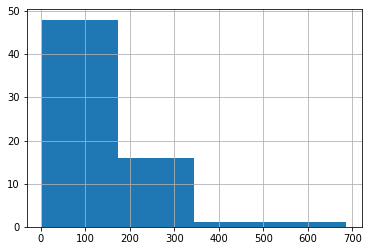

29.0
58.5
195.5


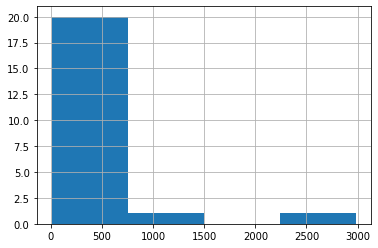

26.5
114.5
317.5


In [21]:
# Visualize the total likes based on a histogram

import matplotlib.pyplot as plt
import numpy as np

food_venues['total likes'].hist(bins=4)
plt.show()

# Use percentile to find the categories for total likes

print(np.percentile(food_venues['total likes'], 25))
print(np.percentile(food_venues['total likes'], 50))
print(np.percentile(food_venues['total likes'], 75))

t_venues['total likes'].hist(bins=4)
plt.show()

print(np.percentile(t_venues['total likes'], 25))
print(np.percentile(t_venues['total likes'], 50))
print(np.percentile(t_venues['total likes'], 75))

For restaurants, we get the 25th percentile is 28, the 50th percentile is 56, and the 75th percentile is 190.  
Then we can set 4 categories: poor, below average, above average, and great; corresponding to the number of likes below 28.5, between 28 and 56, between 58 and 190, and above 190, respectively;  
and for landmarks / stores, we get the 25th percentile is 28, the 50th percentile is 115, and the 75th percentile is 317.  
Then we can set 4 categories: poor, below average, above average, and great; corresponding to the number of likes below 28, between 28 and 115, between 115 and 317, and above 317, respectively.

In [22]:
# Restaurants: less than 28, 28-58, 58-193, above 193
# poor, below avg, abv avg, great

poor = food_venues['total likes']<=28
below_avg = food_venues[(food_venues['total likes']>28) & (food_venues['total likes']<=56)]
abv_avg = food_venues[(food_venues['total likes']>56) & (food_venues['total likes']<=190)]
great = food_venues['total likes']>190

# Tours: less than 29, 29-114, 114-316, above 316
# poor, below avg, abv avg, great

poor_t = t_venues['total likes']<=28
below_avg_t = t_venues[(t_venues['total likes']>28) & (t_venues['total likes']<=115)]
abv_avg_t = t_venues[(t_venues['total likes']>115) & (t_venues['total likes']<=317)]
great_t = t_venues['total likes']>317

# Set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=28:
        return 'poor'
    elif s['total likes']<=56:
        return 'below avg'
    elif s['total likes']<=190:
        return 'above avg'
    else:
        return 'great'

def conditions_t(s):
    if s['total likes']<=28:
        return 'poor'
    elif s['total likes']<=115:
        return 'below avg'
    elif s['total likes']<=317:
        return 'above avg'
    else:
        return 'great'
    
food_venues['total likes_cat']=food_venues.apply(conditions, axis=1)
t_venues['total likes_cat']=t_venues.apply(conditions_t, axis=1)
print (food_venues.head())
print (t_venues.head())

                  name                        id            categories  \
2              Japango  4ae7b27df964a52068ad21e3      Sushi Restaurant   
4         Chatime 日出茶太  4e2284b11fc7c0ef9857d143       Bubble Tea Shop   
5            Poke Guys  57bcd3b7498e652a678d0378            Poke Place   
11     Crepe Delicious  4e5d8181a8092f63968617ee  Fast Food Restaurant   
13  M Square Coffee Co  54132b3b498ee9ca9332e189           Coffee Shop   

          lat        lng  total likes total likes_cat  
2   43.655268 -79.385165          161       above avg  
4   43.655542 -79.384684          198           great  
5   43.654895 -79.385052           32       below avg  
11  43.654536 -79.380889            8            poor  
13  43.651218 -79.383555           32       below avg  
                       name                        id      categories  \
0          Downtown Toronto  5227bb01498e17bf485e6202    Neighborhood   
1    Nathan Phillips Square  4ad4c05ef964a520a6f620e3           Plaza   


In [23]:
# Show the current categories first
print (food_venues['categories'].unique())
print (len(food_venues['categories'].unique()))
print (t_venues['categories'].unique())
print (len(t_venues['categories'].unique()))

['Sushi Restaurant' 'Bubble Tea Shop' 'Poke Place' 'Fast Food Restaurant'
 'Coffee Shop' 'American Restaurant' 'Vegetarian / Vegan Restaurant'
 'Seafood Restaurant' 'Steakhouse' 'Gastropub' 'Pizza Place'
 'Modern European Restaurant' 'Café' 'Food Court' 'Speakeasy'
 'Burger Joint' 'Burrito Place' 'Breakfast Spot' 'New American Restaurant'
 'Sandwich Place' 'Bakery' 'Jazz Club' 'Asian Restaurant'
 'Ramen Restaurant' 'Thai Restaurant' 'Middle Eastern Restaurant'
 'Mexican Restaurant' 'Mediterranean Restaurant' 'Souvlaki Shop'
 'Japanese Restaurant' 'Italian Restaurant' 'Gluten-free Restaurant'
 'Brazilian Restaurant']
33
['Neighborhood' 'Plaza' 'Cosmetics Shop' 'Art Museum' 'Shopping Mall'
 'Concert Hall' 'Monument / Landmark' 'Clothing Store'
 'Miscellaneous Shop' 'Department Store' 'Comic Shop' 'Smoke Shop'
 'Opera House' 'Hotel' 'Electronics Store' 'Music Venue'
 'Arts & Crafts Store' 'Furniture / Home Store' 'Park']
19


In [24]:
# Create new categories to summarize th data and to reduce the number of existing categories
# Here I have refered to the categories on UberEat :)

bars = ['Speakeasy', 'Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar', 'Jazz Club', 'Gastropub']
other_tour = ['Park', 'Smoke Shop', 'Concert Hall', 'Neighborhood', 'Art Museum',  'Hotel', 'Opera House', 'Bank', 'Music Venue', 'Movie Theater', 'Plaza', 'Monument / Landmark', 'Theater']
shopping = ['Cosmetics Shop', 'Arts & Crafts Store', 'Shopping Mall', 'Miscellaneous Shop', 'Clothing Store', 'Furniture / Home Store', 'Shoe Store', 'Tanning Salon', 'Electronics Store', 'Department Store', 'Comic Shop']
sweets_beverage = [ 'Juice Bar', 'Bakery', 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Boutique', 'Ice Cream Shop', 'Café', 'Smoothie Shop']
mex_southam_food = ['Burrito Place', 'Brazilian Restaurant', 'Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['American Restaurant', 'New American Restaurant', 'Steakhouse','Restaurant', 'Diner', 'Poke Place']
euro_italian_food = ['Mediterranean Restaurant', 'Modern European Restaurant','Italian Restaurant', 'Seafood Restaurant']
fast_food = ['Food Court', 'Pizza Place', 'Burger Joint', 'Fast Food Restaurant']
breakfast = ['Bagel Shop', 'Sandwich Place', 'Breakfast Spot']
vegan_glutenfree = ['Vegetarian / Vegan Restaurant', 'Salad Place', 'Gluten-free Restaurant']
middle_east_food = ['Souvlaki Shop', 'Middle Eastern Restaurant',  'Falafel Restaurant', 'Indian Restaurant']
asia_food = ['Asian Restaurant', 'Ramen Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Noodle House']
thai_Vietnamese_food = ['Thai Restaurant', 'Vietnamese Restaurant']



def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in sweets_beverage:
        return 'sweet and beverage'
    if s['categories'] in other_tour:
        return 'other_tour'
    if s['categories'] in asia_food:
        return 'asia food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in middle_east_food:
        return 'middle east food'
    if s['categories'] in thai_Vietnamese_food:
        return 'thai vietnamese food'
    if s['categories'] in euro_italian_food:
        return 'euro italian food'
    if s['categories'] in fast_food:
        return 'fast food'
    if s['categories'] in breakfast:
        return 'breakfast'
    if s['categories'] in vegan_glutenfree:
        return 'vegan gluten free'
    if s['categories'] in shopping:
        return 'shopping'
    

food_venues['categories_new']=food_venues.apply(conditions2, axis=1)
food_venues


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165,161,above avg,asia food
4,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684,198,great,sweet and beverage
5,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052,32,below avg,american food
11,Crepe Delicious,4e5d8181a8092f63968617ee,Fast Food Restaurant,43.654536,-79.380889,8,poor,fast food
13,M Square Coffee Co,54132b3b498ee9ca9332e189,Coffee Shop,43.651218,-79.383555,32,below avg,sweet and beverage
...,...,...,...,...,...,...,...,...
94,Kupfert & Kim (First Canadian Place),50e44770e4b0e03a48c0d8a8,Gluten-free Restaurant,43.648547,-79.381624,47,below avg,vegan gluten free
95,Copacabana Grilled Brazilian,52ec621e498ec68fa15ee922,Brazilian Restaurant,43.648333,-79.388151,149,above avg,mex southam food
97,Beerbistro,4b5ca7d8f964a5207c3c29e3,Gastropub,43.649419,-79.377237,325,great,bars
98,Jimmy's Coffee,57fe5f64498e08c9fc55cb87,Café,43.655827,-79.392042,32,below avg,sweet and beverage


In [25]:
t_venues['categories_new']=t_venues.apply(conditions2, axis=1)
t_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,above avg,other_tour
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other_tour
6,LUSH,4bd0b30d41b9ef3b8fa0fae5,Cosmetics Shop,43.653557,-79.380400,22,poor,shopping
7,Textile Museum of Canada,4ad4c05ef964a520e2f620e3,Art Museum,43.654396,-79.386500,25,poor,other_tour
8,CF Toronto Eaton Centre,4ad77a12f964a520260b21e3,Shopping Mall,43.654447,-79.380952,2986,great,shopping
9,Four Seasons Centre for the Performing Arts,4ad4c062f964a520e5f720e3,Concert Hall,43.650592,-79.385806,222,above avg,other_tour
10,Old City Hall,4ad4c05ef964a5208ef620e3,Monument / Landmark,43.652009,-79.381744,73,below avg,other_tour
12,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,Clothing Store,43.655910,-79.380641,114,below avg,shopping
17,MUJI,5479da4f498e8569fb44985c,Miscellaneous Shop,43.656024,-79.383284,135,above avg,shopping
20,Yonge-Dundas Square,4ad8cd16f964a520c91421e3,Plaza,43.656054,-79.380495,823,great,other_tour


In [26]:
# one hot encoding
food_onehot = pd.get_dummies(food_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")
t_onehot = pd.get_dummies(t_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
food_onehot['Name'] = food_venues['name'] 
t_onehot['Name'] = t_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [food_onehot.columns[-1]] + list(food_onehot.columns[:-1])
food_onehot = food_onehot[fixed_columns]

fixed_columns_t = [t_onehot.columns[-1]] + list(t_onehot.columns[:-1])
t_onehot = t_onehot[fixed_columns_t]

print (food_onehot.head())
print (t_onehot.head())

                  Name  american food  asia food  bars  breakfast  \
2              Japango              0          1     0          0   
4         Chatime 日出茶太              0          0     0          0   
5            Poke Guys              1          0     0          0   
11     Crepe Delicious              0          0     0          0   
13  M Square Coffee Co              0          0     0          0   

    euro italian food  fast food  mex southam food  middle east food  \
2                   0          0                 0                 0   
4                   0          0                 0                 0   
5                   0          0                 0                 0   
11                  0          1                 0                 0   
13                  0          0                 0                 0   

    sweet and beverage  thai vietnamese food  vegan gluten free  above avg  \
2                    0                     0                  0          1

In [27]:
cluster_df = food_onehot.drop('Name', axis=1)
cluster_df_t = t_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)
kmeans_t = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df_t)

# check cluster labels generated for each row in the dataframe
print (kmeans.labels_)
print (kmeans_t.labels_)

[3 1 2 0 2 1 2 0 1 0 1 3 0 1 3 3 2 2 1 1 3 2 3 0 3 0 2 2 1 0 1 0 1 2 3 0 0
 0 1 3 0 3 1 3 1 1 1 2 0 2 3 2 3 3 3 2 0 0 1 3 2 2 3 1 2 0]
[1 1 0 2 0 1 1 3 0 1 0 3 2 2 1 0 2 3 3 2 1 1]


In [30]:
food_venues['label'] = kmeans.labels_
t_venues['label'] = kmeans_t.labels_
print (food_venues.head())
t_venues

                  name                        id            categories  \
2              Japango  4ae7b27df964a52068ad21e3      Sushi Restaurant   
4         Chatime 日出茶太  4e2284b11fc7c0ef9857d143       Bubble Tea Shop   
5            Poke Guys  57bcd3b7498e652a678d0378            Poke Place   
11     Crepe Delicious  4e5d8181a8092f63968617ee  Fast Food Restaurant   
13  M Square Coffee Co  54132b3b498ee9ca9332e189           Coffee Shop   

          lat        lng  total likes total likes_cat      categories_new  \
2   43.655268 -79.385165          161       above avg           asia food   
4   43.655542 -79.384684          198           great  sweet and beverage   
5   43.654895 -79.385052           32       below avg       american food   
11  43.654536 -79.380889            8            poor           fast food   
13  43.651218 -79.383555           32       below avg  sweet and beverage   

    label  
2       3  
4       1  
5       2  
11      0  
13      2  


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,above avg,other_tour,1
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other_tour,1
6,LUSH,4bd0b30d41b9ef3b8fa0fae5,Cosmetics Shop,43.653557,-79.380400,22,poor,shopping,0
7,Textile Museum of Canada,4ad4c05ef964a520e2f620e3,Art Museum,43.654396,-79.386500,25,poor,other_tour,2
8,CF Toronto Eaton Centre,4ad77a12f964a520260b21e3,Shopping Mall,43.654447,-79.380952,2986,great,shopping,0
9,Four Seasons Centre for the Performing Arts,4ad4c062f964a520e5f720e3,Concert Hall,43.650592,-79.385806,222,above avg,other_tour,1
10,Old City Hall,4ad4c05ef964a5208ef620e3,Monument / Landmark,43.652009,-79.381744,73,below avg,other_tour,1
12,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,Clothing Store,43.655910,-79.380641,114,below avg,shopping,3
17,MUJI,5479da4f498e8569fb44985c,Miscellaneous Shop,43.656024,-79.383284,135,above avg,shopping,0
20,Yonge-Dundas Square,4ad8cd16f964a520c91421e3,Plaza,43.656054,-79.380495,823,great,other_tour,1


Let's list the restaurants and buildings group by differen likes categories

In [31]:
# list of restaurants and buildings with cluster 0

print (food_venues.loc[food_venues['label'] == 0])
t_venues.loc[t_venues['label'] == 0]

                            name                        id  \
11               Crepe Delicious  4e5d8181a8092f63968617ee   
19      John & Sons Oyster House  50ecb1fae4b0beb13294f0aa   
22          Bulldog On The Block  5a3a846af62e0960e9364d11   
27       The Elm Tree Restaurant  539c6f13498e06f4cc765165   
44                   Cafe Plenty  4f513029e4b07c3382c9fdb9   
46  The Library Specialty Coffee  5a6b737b35f98359eed11974   
53         Pilot Coffee Roasters  59cd51c71b0ea516e9e7b3aa   
55           Brick Street Bakery  4dcbf219d22d7ffe9d39197e   
61                        Panago  4ad4cba2f964a520d1fb20e3   
62                   Tokyo Smoke  5a55078bda5ede6ed9d73a62   
63         Hakata Ikkousha Ramen  5c9aaa3f66f3cd002c95bd58   
67        Somethin' 2 Talk About  4b744336f964a520d8d02de3   
79              Omg! Oh My Gyro!  595d4380c876c841c08f1959   
88                        Pi Co.  5a5a59c5a423620ec1dafd41   
89                   Café Plenty  53c524bd498efaeebf73b291   
99      

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
6,LUSH,4bd0b30d41b9ef3b8fa0fae5,Cosmetics Shop,43.653557,-79.380400,22,poor,shopping,0
8,CF Toronto Eaton Centre,4ad77a12f964a520260b21e3,Shopping Mall,43.654447,-79.380952,2986,great,shopping,0
17,MUJI,5479da4f498e8569fb44985c,Miscellaneous Shop,43.656024,-79.383284,135,above avg,shopping,0
24,Hudson's Bay,4adf85e1f964a5206e7b21e3,Department Store,43.652040,-79.380391,573,great,shopping,0
33,Apple Eaton Centre,4ad788c8f964a520e40b21e3,Electronics Store,43.652818,-79.380617,493,great,shopping,0


In [32]:
# list of restaurants and buildings with cluster 1

print (food_venues.loc[food_venues['label'] == 1])
t_venues.loc[t_venues['label'] == 1]

                                      name                        id  \
4                             Chatime 日出茶太  4e2284b11fc7c0ef9857d143   
14                        Richmond Station  506db1a9e4b0a3f3b31412f0   
21  The Keg Steakhouse + Bar - York Street  4ad69511f964a520e40721e3   
23       The Queen and Beaver Public House  4ab2b0b9f964a520e56b20e3   
30                           Dineen Coffee  514627d1e4b0dba1b85e9ba8   
38                      Soho House Toronto  50322b6ae4b09116a296568c   
39                               Five Guys  5064c3dde4b07c5a18986283   
52                        Cactus Club Cafe  55fc571f498ec35023360858   
54                            Banh Mi Boys  51755dc7498ece19b7261641   
56          The Rex Hotel Jazz & Blues Bar  4b68aed1f964a520de862be3   
64                                     Pai  529612de11d2ab526191ccc9   
70                                   Canoe  4ad4c05df964a52059f620e3   
73         Hokkaido Ramen Santouka らーめん山頭火  509e9ef6e4b0ab175389

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,above avg,other_tour,1
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other_tour,1
9,Four Seasons Centre for the Performing Arts,4ad4c062f964a520e5f720e3,Concert Hall,43.650592,-79.385806,222,above avg,other_tour,1
10,Old City Hall,4ad4c05ef964a5208ef620e3,Monument / Landmark,43.652009,-79.381744,73,below avg,other_tour,1
20,Yonge-Dundas Square,4ad8cd16f964a520c91421e3,Plaza,43.656054,-79.380495,823,great,other_tour,1
32,Shangri-La Toronto,4e31b74252b131dcebb08743,Hotel,43.649129,-79.386557,181,above avg,other_tour,1
93,Grange Park,4b54deadf964a520a3d027e3,Park,43.652488,-79.392053,45,below avg,other_tour,1
96,Roy Thomson Hall,4ad4c061f964a520b0f720e3,Concert Hall,43.646589,-79.385979,318,great,other_tour,1


In [33]:
# list of restaurants and buildings with 'below_average' likes

print (food_venues.loc[food_venues['label'] == 2])
t_venues.loc[t_venues['label'] == 2]

                                    name                        id  \
5                              Poke Guys  57bcd3b7498e652a678d0378   
13                    M Square Coffee Co  54132b3b498ee9ca9332e189   
18                             Rosalinda  5aff06ca6e4650002cc6286b   
36                       Hy's Steakhouse  4bd8cde92e6f0f47dcb20808   
37                         Hailed Coffee  5a81ae339deb7d369fa7f146   
42                          Burrito Boyz  55a9bbf9498e00ffd7f4c71f   
49         The Black Canary Espresso Bar  506a2591e4b0961239b8c825   
51                          Cafe Landwer  5b6c842bc36588002c80a934   
57                       HotBlack Coffee  59f784dd28122f14f9d5d63d   
78                        Mos Mos Coffee  52138db911d22803b334c641   
80                           Tim Hortons  557231e3498e540f05f3083c   
82              Hawthorne Food and Drink  505c7c30e4b071a17ec2678f   
87                 Gyu-Kaku Japanese BBQ  574ad72238fa943556d93b8e   
92                  

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
7,Textile Museum of Canada,4ad4c05ef964a520e2f620e3,Art Museum,43.654396,-79.386500,25,poor,other_tour,2
28,Friendly Stranger - Cannabis Culture Shop,4b7ed424f964a5208a0230e3,Smoke Shop,43.650387,-79.388523,17,poor,other_tour,2
29,Canadian Opera Company,4ad4c062f964a520baf720e3,Opera House,43.650660,-79.386242,21,poor,other_tour,2
41,Jazz Bistro,514cc159e4b0e4f73af4eced,Music Venue,43.655678,-79.379276,24,poor,other_tour,2
75,College Park Area,4c8facf91664b1f79c90aa2f,Park,43.659453,-79.383785,9,poor,other_tour,2


In [34]:
# list of restaurants and buildings with 'poor' likes

print (food_venues.loc[food_venues['label'] == 3])
t_venues.loc[t_venues['label'] == 3]

                            name                        id  \
2                        Japango  4ae7b27df964a52068ad21e3   
25                   Blaze Pizza  5615b6c4498e3c32c67ad78f   
31          Assembly Chef's Hall  5a32970da42362290203a9d6   
35                      JaBistro  509bb871e4b09c7ac93f6642   
40                Jimmy's Coffee  537d4d6d498ec171ba22e7fe   
43                      Karine's  4c90c810ae96a093599f9d46   
45                     The Chase  5214e7c111d2a83379eae21f   
60            Bosk at Shangri-La  50468014e4b01c18bb731df8   
66                         Maman  559a8f5a498e31f945041245   
69        Chipotle Mexican Grill  4adc9148f964a520512d21e3   
72                     King Taps  59603f86112c6c70931c9401   
81             GEORGE Restaurant  4af618daf964a520220122e3   
83   Sam James Coffee Bar (SJCB)  4fccaa8fe4b05a98df3d9417   
85                 Page One Cafe  56d4d1b3cd1035fe77e1492c   
86              Vegetarian Haven  4aeb711ef964a52017c221e3   
91      

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
12,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,Clothing Store,43.655910,-79.380641,114,below avg,shopping,3
26,Silver Snail Comics,4ad4c062f964a5200bf820e3,Comic Shop,43.657031,-79.381403,115,below avg,shopping,3
47,Aboveground Art Supplies,4adf3c01f964a5208f7821e3,Arts & Crafts Store,43.652646,-79.390925,35,below avg,shopping,3
71,Umbra Concept Store,4ae734bef964a5205ea921e3,Furniture / Home Store,43.650417,-79.391136,31,below avg,shopping,3


Now let's plot a map and add marks on it.  
We'll use gray marks for 'poor' likes, green for 'below average', orange for 'above average', and red for 'great'; 
circles for tour data, and circles with filled colors for restaurants data.

For restaurants data, cluster 0 represents 'poor' likes, cluster 1 represents 'great', cluster 2 represents 'below_avg', 
and cluster 3 represents 'above_avg';  
and for tour data, cluster 0 represents shopping category, cluster 1 represents other_tour, clustr 2 represents 'poor' for other_tour category, 
and cluster 3 represents 'below_avg' for shopping category.

In [37]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['gray', 'red', 'green', 'orange']
rainbow_t = ['red', 'orange', 'gray', 'green']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, likes in zip(food_venues['lat'], food_venues['lng'],
                                         food_venues['name'], food_venues['label'], food_venues['total likes_cat']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' ' + str(likes), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster],
        fill=False,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters)
    


for lat, lon, poi, cluster, likes in zip(t_venues['lat'], t_venues['lng'],
                                  t_venues['name'], t_venues['label'], t_venues['total likes_cat']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+ ' ' + str(likes), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow_t[cluster],
        fill=False).add_to(map_clusters)

map_clusters

## Conclusion

Since we only pulled some data of restaurants/ neighborhoods located in Downtown Toronto, we will only analysis downtown area.
From the numerical and geographical data shown above, we can see that most of the restaurants are located on or nearby Yonge Street and the area between Osgoode & King. So it is not recommanded to open a new restaurant in these areas due to the competitive environment.
However, among these restaurants, many of them with 'poor' likes are cafe/ tea shop/ sweet shop. If someone is very confident about starting a cafe/ bubble tea shop business, there might still be a chance to win customers' heart.
In the area between Patrick and Queen, there are many shopping malls, parks, and some places for entertainment, which will attract tourists and local people and can be helpful for improving customer flow. Besides, there are not many restaurants in this area, so it is a good place to open a new restaurant.